In [ ]:
import networkx as nx

import numpy as np
import os

from scipy import ndimage

from numpy import loadtxt
from lmfit.models import GaussianModel,Model
from sklearn.linear_model import LinearRegression
from sklearn import mixture,metrics

from shapely.geometry import Polygon

from scipy.stats.distributions import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

    
from matplotlib import pyplot as plt
from matplotlib import cm

from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D


from scipy import ndimage as ndi
from scipy.spatial import ConvexHull
from scipy.spatial import distance
from numpy import linalg 

from skimage import io
from skimage.morphology import medial_axis, skeletonize
from skimage.draw import ellipse
from skimage.color import rgb2gray
from skimage import filters
from skimage.morphology import disk
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

import copy
import cv2

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.ndimage import distance_transform_edt as edt

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon,subdivide_polygon

from radio_beam.commonbeam import getMinVolEllipse

from utils import grainPreprocess,grainShow,grainMark,grainDraw,grainApprox,grainStats,grainMorphology



In [ ]:
def img_load_preprocess(path,names,h=150,k=1):
    imgs_path=[path+'/'+name for name in names]
    imgs=[]
    for img_path in imgs_path:
        img=io.imread(img_path)
        img=grainPreprocess.image_preprocess(img,h,k)
        imgs.append(img)
    return imgs

In [ ]:
path='images'
grain_names=['Ultra_Co8.jpg','Ultra_Co11.jpg','Ultra_Co6_2.jpg','Ultra_Co15.jpg','Ultra_Co25.jpg']
grain_images=img_load_preprocess(path,grain_names)

In [ ]:
def get_tree(img):
    #
    # вовзращает скелеты изображения, где каждый пиксель скелета
    # отображает порядковый номер скелета
    #
    image=img.copy()/255
    skeleton = np.array(skeletonize(image))
    labels,classes_num=ndimage.label(image)
    
    bones=[[] for i in range(classes_num+1)]
    
    # создает массив индивидуальных скелетов
    # пикселю скелета дается класс, на координатах которого он находится
    # координаты класса определяются ndi.label
    
    for i in range(skeleton.shape[0]):
        for j in range(skeleton.shape[1]):
            if skeleton[i,j]:
                label=labels[i,j]
                bones[label].append((i,j))

    leafs=[[] for i in range(classes_num+1)]
    nodes=[[] for i in range(classes_num+1)]
    temp_skeleton=skeleton.copy()
    
    # определение узлов и листьев при помощи свертки
    for i,bone in enumerate(bones):
        
        for pixel in bone:
            
            nodes_coords=grainStats.kernel_points(temp_skeleton,pixel)
            leafs_coords=grainStats.kernel_points(skeleton,pixel)
            
            nodes_val=0
            for point in nodes_coords:
                if temp_skeleton[point]:
                    nodes_val+=1
                    
            leafs_val=0
            for point in leafs_coords:
                if skeleton[point]:
                    leafs_val+=1
                    
            
            if nodes_val>3:
                nodes[i].append(pixel)
                
                for n in nodes_coords:
                    temp_skeleton[n]=False
                
            if leafs_val==2:
                leafs[i].append(pixel)


    return leafs,nodes,classes_num+1

In [ ]:
def tree_stats(leafs,nodes):   
    leafs_num=np.full((len(leafs)),2)
    nodes_num=np.zeros((len(nodes)))

    for i,leaf in enumerate(leafs):
        if len(leaf)>1:
            leafs_num[i] = len(leaf)

    for i,node in enumerate(nodes):
            nodes_num[i] = len(node)

    return leafs_num,nodes_num

In [ ]:
def tree_dens(array):
    array_copy=array.copy()
    
    array_copy_set=np.sort(np.array(list(set(array_copy))))
    dens_curve=[]
    for arr in array_copy_set:
        num=0
        for ar in array_copy:
            if arr==ar:
                num+=1
        dens_curve.append(num)
    
    dens_curve=np.array(dens_curve)
    return array_copy_set,dens_curve

In [ ]:
def apprx_tree(images,names):
    
    for k,image in enumerate(images):
        leafs,nodes,classes_num=get_tree(image)
        leafs_num,nodes_num=tree_stats(leafs,nodes)

        x1,y1=tree_dens(leafs_num)
        x2,y2=tree_dens(nodes_num)
        x2=x2[1:]
        y2=y2[1:]

        norm1=sum(y1)
        norm2=sum(y2)

        x1=np.log(x1.reshape((-1,1)))
        y1=np.log(y1.reshape((-1,1))/norm1)
        x2=np.log(x2.reshape((-1,1)))
        y2=np.log(y2.reshape((-1,1))/norm2)

        x_linear1=np.linspace(0.5,x1.max(axis=0),50).reshape(-1, 1)
        x_linear2=np.linspace(0,x2.max(axis=0),50).reshape(-1, 1)

        reg1 = LinearRegression().fit(x1,y1)
        reg2 = LinearRegression().fit(x2,y2)

        lin_predict1=reg1.predict(x_linear1)
        lin_predict2=reg2.predict(x_linear2)

        k1=reg1.coef_[0][0]
        k2=reg2.coef_[0][0]

        angle1=round(np.rad2deg(np.arctan(k1)),4)
        angle2=round(np.rad2deg(np.arctan(k2)),4)

        score1=round(reg1.score(x1, y1),2)
        score2=round(reg2.score(x2, y2),2)

        lin_k1='\n угол наклона '+str(angle1)+' градусов'
        acc1='\n точность '+str(score1)
        text1='\nколичество листьев '+str(norm1)+lin_k1+acc1

        lin_k2='\n угол наклона '+str(angle2)+' градусов'
        acc2='\n точность '+str(score2)
        text2='\nколичество узлов '+str(norm2)+lin_k2+acc2


        bins=10
        fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(15,15))

        ax1.imshow(image,cmap='gray')

        ax2.plot(x_linear1,lin_predict1)
        ax2.plot(x_linear2,lin_predict2)
        ax2.scatter(x1,y1)
        ax2.scatter(x2,y2)

        ax2.legend([names[k]+text1,text2],fontsize=15)
        ax2.set_ylabel('ln(p(x))',fontsize=15)
        ax2.set_title('распределение узлов и листьев по количеству',fontsize=15)
        ax2.set_xlabel('ln(количество в скелете)',fontsize=15)
        plt.savefig('leafs-and-nodes-ditr '+names[k])
        plt.show()



In [ ]:

names=grain_names[:]
images=grain_images[:]

apprx_tree(images,names)

In [ ]:
def approx_leafs_nodes(image,name):
    leafs,nodes,classes_num=get_tree(image)
    leafs_num,nodes_num=tree_stats(leafs,nodes)

    k=nodes_num/leafs_num
    x,y=tree_dens(k)



    leafs_number=sum(leafs_num)
    nodes_number=sum(nodes_num)


    x=leafs_num
    y=nodes_num


    fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(12,12))
    ax1.imshow(image,cmap='gray')


    #ax2.plot(y,x)
    ax2.scatter(x,y)
    leafs_text='\nколичество листьев '+str(leafs_number)
    nodes_text='\nколичество листьев '+str(int(nodes_number))
    text=name+leafs_text+nodes_text

    ax2.legend([text],fontsize=15)
    ax2.set_ylabel('количество узлов в дереве',fontsize=15)
    ax2.set_xlabel('количество листьев в дереве',fontsize=15)
    
    ax2.set_title('распределение узлов по листьям',fontsize=15)
    plt.savefig('leafs-and-nodes-correlation-'+name)
    
    plt.show()

In [ ]:
names=grain_names[:]
images=grain_images[:]

for pos in range(4):
    approx_leafs_nodes(images[pos],names[pos])

In [ ]:
def approx_leafs_nodes_3d(image,name):
    leafs,nodes,classes_num=get_tree(image)
    leafs_num,nodes_num=tree_stats(leafs,nodes)

    x=np.array(leafs_num).reshape((-1,1))
    y=np.array(nodes_num).reshape((-1,1))

    xy=np.concatenate([x,y],axis=1).astype('int32')

    count_map=np.zeros((x.shape[0],x.shape[0]))
    z=np.zeros((x.shape[0]))
    for xi,yi in xy:
        count_map[xi,yi]+=1
    for i,(xi,yi) in enumerate(xy):
        z[i]=count_map[xi,yi]


    #x=np.log(x)
    #y=np.log(y)
    #z=np.log(z)

    N=10

    leafs_number=sum(leafs_num)
    nodes_number=sum(nodes_num)

    leafs_text='\nколичество листьев '+str(leafs_number)
    nodes_text='\nколичество листьев '+str(int(nodes_number))
    text=name+leafs_text+nodes_text


    fig = plt.figure(figsize=(N,N))
    ax = Axes3D(fig)
    ax.view_init(25, -35)
    ax.scatter(x,y,z,cmap = cm.plasma)
    ax.legend([name+text],fontsize=15)

    ax.set_xlabel('количество листьев',fontsize=15)
    ax.set_ylabel('количество узлов',fontsize=15)
    ax.set_zlabel('количество совпадений',fontsize=15)
    
    ax.set_title('распределение узлов по листьям',fontsize=15)
    plt.savefig('leafs-and-nodes-correlation-3d-'+name)
    
    plt.show()

In [ ]:
names=grain_names[:]
images=grain_images[:]

for pos in range(4):
    approx_leafs_nodes_3d(images[pos],names[pos])

## Центр скелета

In [125]:
# получение графа скелета
def trees_graphs(img):
    graphs=[]
    centres=[]
    image=img.copy()/255
    
    skeleton = np.array(skeletonize(image))
    bones=grainMark.skeletons_coords(image)

    for k,bone in enumerate(bones[1:]):
        # для игнорирования скелетов-шумов
        if len(bone)>0:
            bone=np.array(bone)
         
            # сдвиг каждого скелета к началу координатной плоскости
            x_norm,y_norm=bone.min(axis=0)
            norm_bone=bone.copy()
            norm_bone[:,0]-=x_norm
            norm_bone[:,1]-=y_norm

            # создание матрицы скелета, где каждый пиксель скелета
            # представлен в виде номера позиции в скелете
            # это нужно для перевода (x,y)->i 

            shape=norm_bone.max(axis=0)+1
            bone_matrix=np.zeros(shape,dtype='int16')
            for i,point in enumerate(norm_bone):
                x,y=point
                bone_matrix[x,y]=i

            g = nx.Graph()

            for kernel in bone:
                    # point - центр матрицы свертки
                    # получение набора вершин, которые находятся 
                    # в матрице 3х3
                    coords=grainStats.kernel_points(skeleton,kernel)
                    nodes=[]

                    for t,point in enumerate(coords):
                        # пропускаем середину свертки с индексом 4
                        # это нужно для отсутсвия самосоединений вершин графа
                        if t!=4:
                            xi,yi=point
                            if skeleton[xi,yi]:
                                nodes.append((xi,yi))

                    #  вычисление позиции вершины в скелете
                    kernel_pos=bone_matrix[kernel[0]-x_norm,
                                           kernel[1]-y_norm]

                    
                    for node in nodes:
                        # все точки скелета, которые соседсвуют
                        # с центом, добавляются в граф
                        x=node[0]-x_norm
                        y=node[1]-y_norm
                        # костыль
                        if x<bone_matrix.shape[0] and y<bone_matrix.shape[1]:
                            node_pos= bone_matrix[x,y]
                            
                            g.add_edge(kernel_pos,
                                          node_pos)
                   
                    # если граф состоит из одной вершины и без ребер
                    if len(nodes)==0:    
                        g.add_node(kernel_pos)
            


            graphs.append(g)        
            center_pos=nx.algorithms.distance_measures.center(g)
            center=bone[center_pos[0]]
            centres.append(center)
            
    return graphs,centres


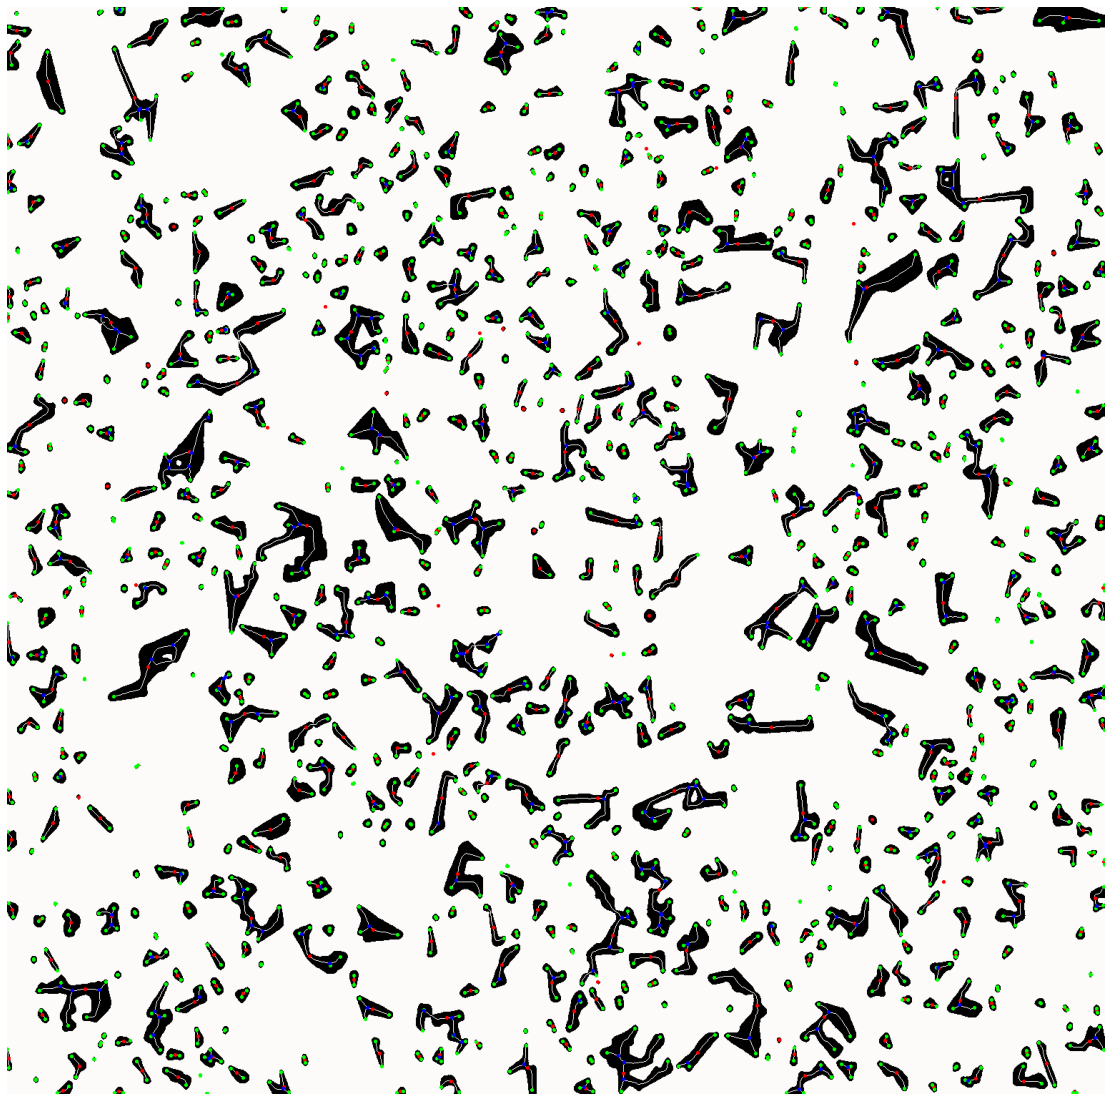

In [126]:
names=grain_names[:]
images=grain_images[:]

for pos in range(1):
    leafs,nodes,classes_num=get_tree(images[pos])
    graphs,centres=trees_graphs(images[pos])
    img=grainDraw.draw_tree(images[pos],centres,leafs,nodes)
 #   io.imsave('Co-tree-'+names[pos]+'.png',img)
    grainShow.img_show(img,cmap='gray')

[28, 30]

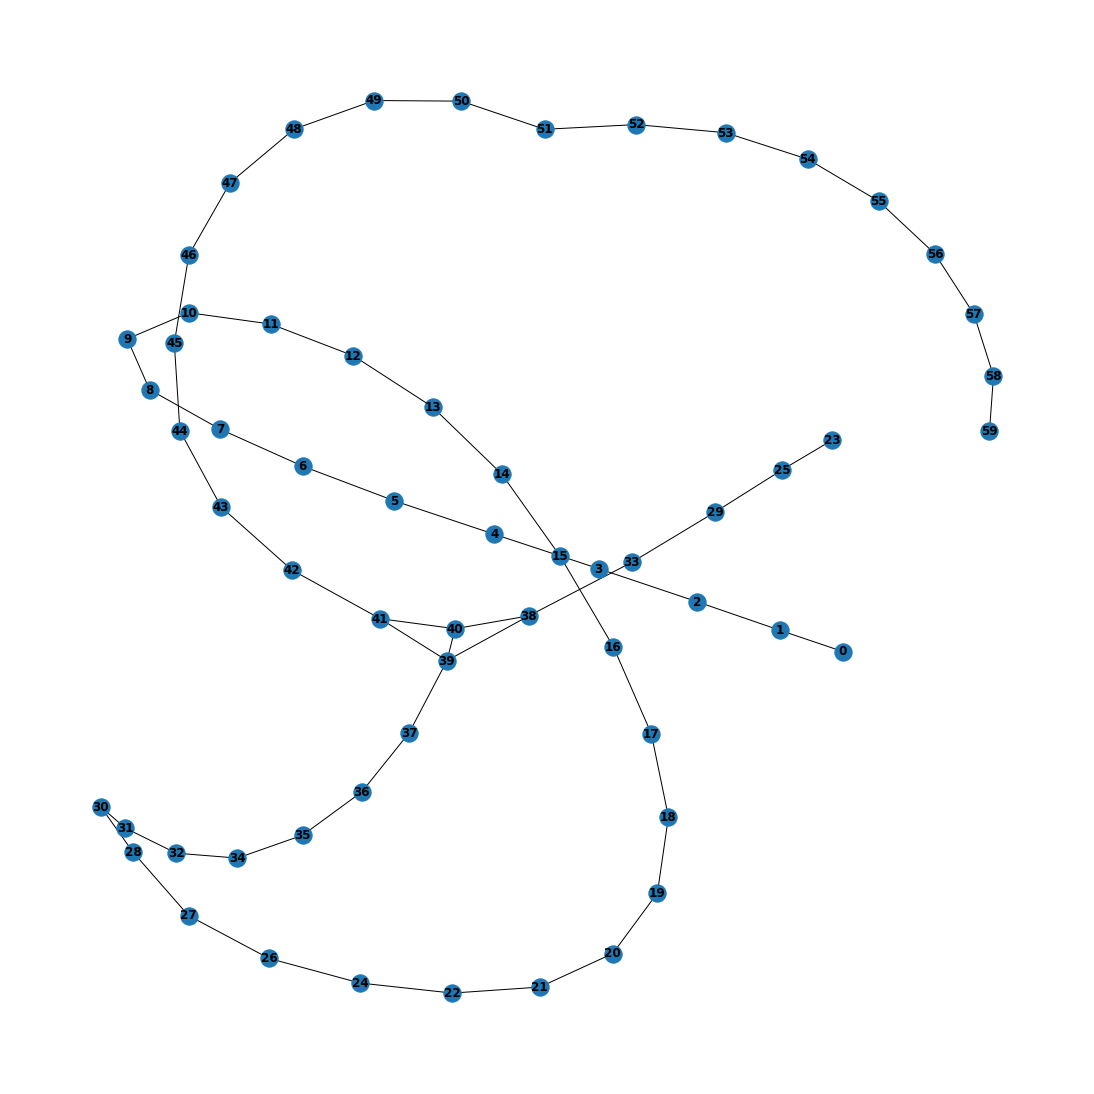

In [127]:
# интересные   1,45

i=45
plt.figure(figsize=(15,15))
nx.draw(graphs[i], with_labels=True, font_weight='bold')
nx.algorithms.distance_measures.center(graphs[i])